<div align="center">

---
# NVIDIA Stock Forecasting
---
</div>

This Project mainly focuses on trying to predict the NVIDIA Stock's Market price using data from the yahoo Finance market history for this stock as well as with Long Short-Term Memory Models (LSTM's).

It is based on Univariate Forecasting - We only consider n previous values to predict the subsequent one.

In [1]:
%load_ext autoreload
%autoreload 2

# Importing Dependencies
import numpy as np
import pandas as pd

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

# Custom Imports
from Configuration import (load_config)

In [2]:
# ADD TO PROJECT DEPENDENCIES
# !pip install yfinance

---
## Dataset Extraction
---

In this Section we extract the market's history data of the NVIDIA Stock to further use in the LSTM's.

In [3]:
# dataset @ https://finance.yahoo.com/quote/NVDA/history/

In [4]:
# Load the config
config = load_config()

In [5]:
# Getting the Stock Market Information
stock_information = yf.Ticker(config['stock'])

# Fetching a dataset with the stock's history data
if config['max_period']:
    stock_history = stock_information.history(period="max")
else:
    stock_history = stock_information.history(start=config['start_date'], end=config['end_date'])

# Saving the History data into a csv file
stock_history.to_csv(f"./{config['stock']}.csv")

In [6]:
# Defining a N degree for the Model - Choosing the amount of previous values to consider for a certain instant
N = 3 if config['N'] is None else config['N']

---
## Dataset PreProcessing
---

In [7]:
# Loading the Dataset
df = pd.read_csv(f"./{config['stock']}.csv")

In [8]:
# Getting the Number of Rows and Columns of the Dataset
n_rows, n_cols = df.shape
print(f"The dataset contains {n_rows} rows and {n_cols} columns")

The dataset contains 422 rows and 8 columns


In [9]:
# Getting Initial / Oldest 5 Records
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-05 00:00:00-05:00,16.669455,16.985274,16.462573,16.600494,352255000,0.0,0.0
1,2022-12-06 00:00:00-05:00,16.520537,16.563512,15.809944,15.977848,352694000,0.0,0.0
2,2022-12-07 00:00:00-05:00,15.762970,16.176733,15.658030,16.110771,372388000,0.0,0.0
3,2022-12-08 00:00:00-05:00,16.263687,17.169168,15.949866,17.159174,515456000,0.0,0.0
4,2022-12-09 00:00:00-05:00,17.150178,17.572936,16.965284,16.991268,465338000,0.0,0.0


In [10]:
# Getting Final / Most Recent 5 Records
df.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
417,2024-08-05 00:00:00-04:00,92.059998,103.410004,90.690002,100.449997,552842400,0.0,0.0
418,2024-08-06 00:00:00-04:00,103.839996,107.709999,100.550003,104.250000,409012100,0.0,0.0
419,2024-08-07 00:00:00-04:00,107.809998,108.800003,98.690002,98.910004,411440400,0.0,0.0
420,2024-08-08 00:00:00-04:00,102.000000,105.500000,97.519997,104.970001,391910000,0.0,0.0
421,2024-08-09 00:00:00-04:00,105.639999,106.599998,103.430000,104.750000,290844200,0.0,0.0


In [11]:
# Formatting the Datetime in order to only keep the date
df['Date'] = df['Date'].apply(lambda x: x.split(' ')[0])
df[['Date']].head(3)

,Date
0,2022-12-05
1,2022-12-06
2,2022-12-07


In [12]:
# Selecting Important Columns
df = df[['Date', 'Close']]
df.head(3)

,Date,Close
0,2022-12-05,16.600494
1,2022-12-06,15.977848
2,2022-12-07,16.110771


In [13]:
# Defining a Function to convert the string dates of the dataset into datetime object instances
def str_to_datetime(string_date:str) -> datetime:
    """
    := param: string_date -> String that we want to convert into a datetime type object [Eg: '2003-10-10']
    := return: Instance of Datetime based on the given date string
    """
    # Fetching the year, month and day from the string and convert them into int
    year, month, day = list(map(int, string_date.split('-')))

    # Return a instance of datetime with the respective extracted attributes from the given string
    return datetime(year=year, month=month, day=day)

In [14]:
# Getting a date string from the dataset [In this case it is the first one]
first_date_dataset = df['Date'][0]

# Testing the previous function on the extracted date
str_to_datetime(first_date_dataset)

datetime.datetime(2022, 12, 5, 0, 0)

In [15]:
# Now, let's update the dataframe in order for the dates to be formated accordingly with this most recent approach
df['Date'] = df['Date'].map(lambda date_string : str_to_datetime(date_string))

# Inspect the result
df['Date']

0     2022-12-05
1     2022-12-06
2     2022-12-07
3     2022-12-08
4     2022-12-09
         ...    
417   2024-08-05
418   2024-08-06
419   2024-08-07
420   2024-08-08
421   2024-08-09
Name: Date, Length: 422, dtype: datetime64[ns]

In [16]:
# Saving the Earliest and Latest Dates to be considered
earliest_date = str(df['Date'][N].date())
latest_date = str(df['Date'][len(df) - 1].date())

In [17]:
# Set the Date column as the index column
df.set_index('Date', inplace=True)

# Inspect the dataframe
df.head(3)

,Close
Date,
2022-12-05,16.600494
2022-12-06,15.977848
2022-12-07,16.110771


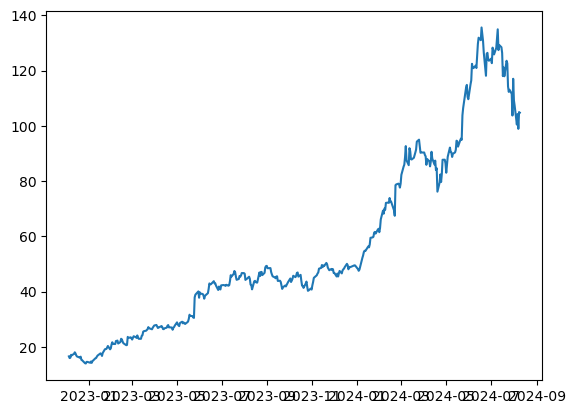

In [18]:
# Plotting the Closing Values of the Stock throughout the years
plt.plot(df.index, df['Close'])

In [19]:
# Since we are going to use a LSTM model, we need to convert the problem into a supervised learning problem


def df_to_windowed_df(dataframe:pd.DataFrame, first_date_str:str, last_date_str:str, n:int=3) -> pd.DataFrame:
    # This function creates a Dataframe with multiple target columns which are going to be used within the long short-term memory model
    # It focus at each instant and it's previous n values to which it will use to train the model and use the real value to control the error fluctuation of the model
    """
    := param: dataframe - Pandas Dataframe with the csv file of the Stock Market History
    := param: first_date_str - First date to consider for the data extraction
    := param: last_date_str - Last date to consider for the data extraction
    := param: n - Number of previous instances to consider when predicting a n+1 instance of the stock market value

    := return: Dataframe with the Target Values alongside the Nth previous values as well as with the corresponding dates
    """
    # Converting the string dates
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    # Defining a current date to be iterated over
    target_date = first_date
    dates, X, Y = [], [], []
    
    # Creating a flag to determine the last time...
    last_time = False

    while True:
        # Selecting a Subset of the datafrane 
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if df_subset.shape[0] != n+1:
            print(f'[ERROR]: Window of Size {n} is too large for date {target_date}')
            return

        # Getting the closing values for the current subset (Current time interval [initial_date - current_date(updates at each new iteration on the while cycle)])
        values = df_subset['Close'].to_numpy()
        
        # Spliting the values into 
        x, y = values[:-1], values[-1]
        
        # Update the initial lists with the new values
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        # Getting the date for the next week -> We consider consecutive entries the ones that are 1 week apart
        next_week = dataframe.loc[target_date:target_date + timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        
        # Extracting the year, month and day
        year, month, day = list(map(int, next_date_str.split('-')))
        
        # Create a new instance of datetime for the next date (date to consider for the next iteration)
        next_date = datetime(year=year, month=month, day=day)

        # Reached the Final / Target date
        if last_time:
            break

        # Updating the Target Date
        target_date = next_date

        # Current Date == Last Date to consider
        if target_date == last_date:
            last_time = True

    # Initializing the Target Dataframe with all the valid dates to which we want to train the model with
    target_df = pd.DataFrame({})
    target_df['Target_Date'] = dates
    
    # Converting the X list into a numpy array
    X = np.array(X, dtype='object')
    
    # For each entry in the dataset, we look for the i - <n> entry and add it as a new column to the dataframe
    for i in range(0, n):
        # X[:, i]
        target_df[f'Target-{n-i}'] = X[:, i]

    target_df['Target'] = Y

    # Return the new dataframe
    return target_df

In [20]:
# Extracting the previous N values of each possible instant along with the target value
windowed_df = df_to_windowed_df(df, 
                                earliest_date, 
                                latest_date, 
                                n=N)
windowed_df.head(5)

,Target_Date,Target-3,Target-2,Target-1,Target
0,2022-12-08,16.600494,15.977848,16.110771,17.159174
1,2022-12-09,15.977848,16.110771,17.159174,16.991268
2,2022-12-12,16.110771,17.159174,16.991268,17.524961
3,2022-12-13,17.159174,16.991268,17.524961,18.061655
4,2022-12-14,16.991268,17.524961,18.061655,17.663881


In [21]:
def windowed_df_to_date_X_y(windowed_df:pd.DataFrame) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    := param: windowed_df - Dataframe with the proper extracted and formated data to later feed models / Tensors
    := return: A list of Dates, a multi-dimensional (Nth Dimensional to be precise) input matrix X and the target values y
    """
    # Convert the whole dataframe into a numpy array
    df_numpy = windowed_df.to_numpy()

    # Get a list with the dates
    dates = df_numpy[:, 0]

    # Filter the input values and reshape them into a matrix
    input_matrix = df_numpy[:, 1:-1]
    X = input_matrix.reshape((len(dates), input_matrix.shape[1], 1))

    # Get the ouput vector
    y = df_numpy[:, -1]

    # Return the dates, the input and output vectors
    return dates, X.astype(np.float32), y.astype(np.float32)

In [22]:
# Get the Dates as well as the input and output vectors
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Verifying the shape of each vector
print(f"{dates.shape=} {X.shape=} {y.shape=}")
assert dates.shape[0] == X.shape[0] and dates.shape[0] == y.shape[0], "Vectors shape not Matching!"

dates.shape=(419,) X.shape=(419, 3, 1) y.shape=(419,)


---
## Data Partitioning (Train - Validation - Test)
---

Now it's time to partition the clean data into proper feature and target vectors (X and y).

In [23]:
# Getting the threshold values for train and validation (To which values should we consider as train/validation sets)
train_threshold = int(len(dates) * .8)
validation_threshold = int(len(dates) * .9)

# Get the Train data
dates_train = dates[:train_threshold]
X_train = X[:train_threshold]
y_train = y[:train_threshold]

# Get the Validation data
dates_validation = dates[train_threshold : validation_threshold]
X_validation = X[train_threshold : validation_threshold]
y_validation = y[train_threshold : validation_threshold]

# Get the Test data
dates_test = dates[validation_threshold:]
X_test = X[validation_threshold:]
y_test = y[validation_threshold:]

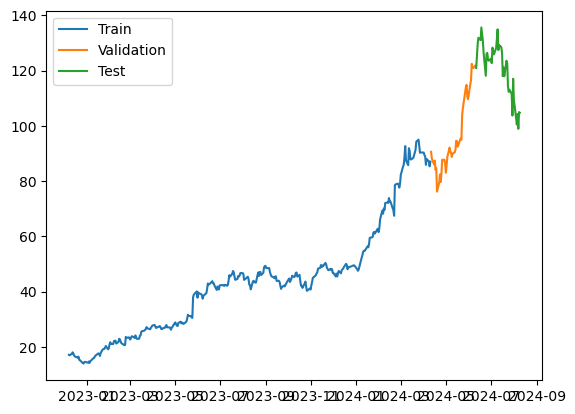

In [24]:
# Plot the Partitioning of the Data (Inspect which values are being used in each set)
plt.plot(dates_train, y_train)
plt.plot(dates_validation, y_validation)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test']);

---
## Model Development
---

In [25]:
# Build the Architecture of the Model
model = Sequential([layers.Input((N,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [26]:
# Insert information to Compile the Model -> Add the Loss Function, the Optimizer and the metrics to consider
# Loss : Mean Squared Error
# Optimizer : Adam with learning rate of 0.001
# Metrics : Mean Absolute Error
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [27]:
# Train the Model
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100)

Epoch 1/100
11/11 [==============================] - 3s 54ms/step - loss: 2262.0874 - mean_absolute_error: 43.1989 - val_loss: 9208.9033 - val_mean_absolute_error: 95.0596
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 2174.5488 - mean_absolute_error: 42.1094 - val_loss: 9023.4199 - val_mean_absolute_error: 94.0768
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 2058.2190 - mean_absolute_error: 40.5825 - val_loss: 8756.8984 - val_mean_absolute_error: 92.6444
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 1862.0248 - mean_absolute_error: 37.8612 - val_loss: 8253.8828 - val_mean_absolute_error: 89.8739
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 1503.6978 - mean_absolute_error: 32.4030 - val_loss: 7219.6147 - val_mean_absolute_error: 83.8717
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 997.4110 - mean_absolute_error: 24.3388 - val_loss: 5438.9619 - val_mea

---
## Model Performance Visualization
---

In [28]:
def plot_model_performance(dates_vector:np.ndarray, predictions_vector:np.ndarray, y_vector:np.ndarray, plot_legend:list) -> None:
    # This function helps plot the performance of the model during Trainning, Validation and Testing
    """
    := param: dates_vector - Array with the corresponding dates
    := param: predictions_vector - Array with the corresponding predictions made by the model
    := param: y_vector - Array with the real values from the stock market price history
    := param: plot_legend - Description to differentiate the multiple vectors
    """
    plt.plot(dates_vector, predictions_vector)
    plt.plot(dates_vector, y_vector)
    plt.legend(plot_legend);

11/11 [==============================] - 0s 3ms/step


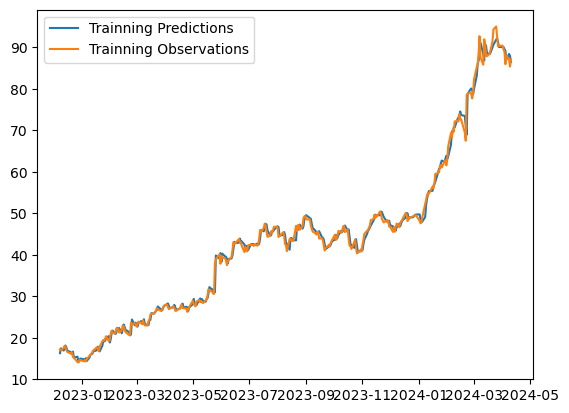

In [29]:
# -> Visualize the Trainning Performance

# Get the Trainning Predictions
train_preds = model.predict(X_train).flatten()

# Plot the Trainning Performance Data
plot_model_performance(dates_train, train_preds, y_train, ['Trainning Predictions', 'Trainning Observations'])

2/2 [==============================] - 0s 4ms/step


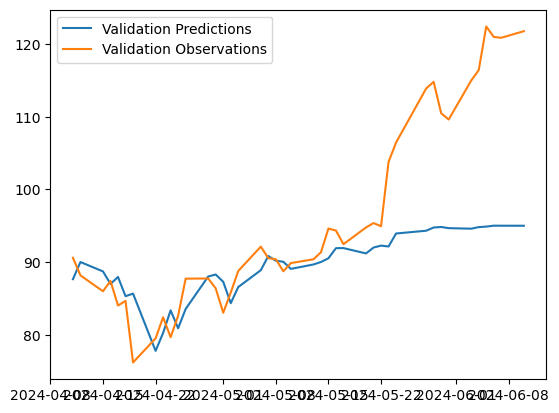

In [30]:
# -> Visualize the Validation Performance

# Get the Validation Predictions
validation_preds = model.predict(X_validation).flatten()

# Plot the Validation Performance Data
plot_model_performance(dates_validation, validation_preds, y_validation, ['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 4ms/step


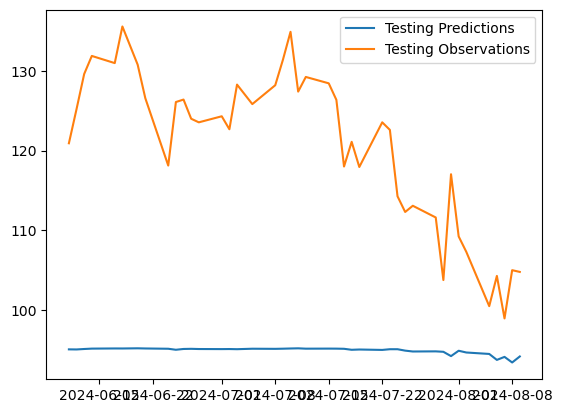

In [31]:
# -> Visualize Test Performance

# Get the Test Predictions
test_preds = model.predict(X_test).flatten()

# Plot the Test Performance Data
plot_model_performance(dates_test, test_preds, y_test, ['Testing Predictions', 'Testing Observations'])

In [32]:
def plot_model_overall_performance(dates_list:list, preds_list:list, y_list:list, plot_legend:list) -> None:
    # This function allows to Visualize the Model's performance throughout Train, Validation and Testing
    """
    := param: dates_list - Python List with all the vectors composed by the dates at each phase: Train, Validation and Test
    := param: preds_list - Python List with all the vectors composed by the model's prediction during Trainning, Valdiation and Testing
    := param: y_list - Python List with all the vectors composed by the actual / real values used in Trainning, Validation and Testing
    := param: plot_legend - Description to differentiate the multiple vectors
    """
    
    # Checking the size of the given lists to make sure they match
    assert len(dates_list) == len(preds_list) and len(preds_list) == len(y_list), "Lists with different sizes!"
    
    # Iterate through the data and add it to the plot
    for i in range(len(dates_list)):
        plt.plot(dates_list[i], preds_list[i])
        plt.plot(dates_list[i], y_list[i])

    # Add a Legend
    plt.legend(plot_legend);

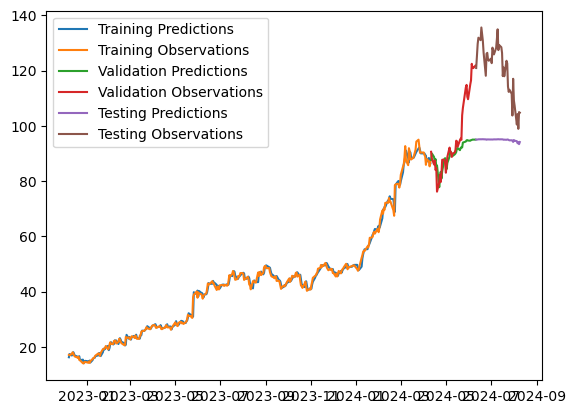

In [33]:
# -> Visualize the Model's performance throughout the all process

# Initialize some python lists with the data
dates_list = [dates_train, dates_validation, dates_test]
preds_list = [train_preds, validation_preds, test_preds]
y_list = [y_train, y_validation, y_test]
legend = ['Training Predictions',
          'Training Observations',
          'Validation Predictions',
          'Validation Observations',
          'Testing Predictions',
          'Testing Observations']

# Plot the Data
plot_model_overall_performance(dates_list, preds_list, y_list, legend)